# About this note
- pytorch
- SSD
- Object Detection

## Library

In [80]:
import glob
import os.path as osp
import random
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
from tqdm import tqdm
import cv2
import xml.etree.ElementTree as ET

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import models,transforms
import torchvision
print('Pytorch ver:',torch.__version__)
print('torchvison ver:',torchvision.__version__)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:',device)

Pytorch ver: 1.7.1
torchvison ver: 0.8.2
device: cpu


In [81]:
# config
class CFG():
    size = 300
    seed = 2021
    pretrained = True

    batch_size = 16
    lr = 0.001

    epoch = 2


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(CFG.seed)

In [82]:
# get image_path
def make_datapath_list(root_path = './data/VOC2012/'):

    image_path = osp.join(root_path, 'JPEGImages','%s.jpg')
    annotation_path = osp.join(root_path, 'Annotations','%s.xml')
    print(image_path)
    print(annotation_path)

    train_id = osp.join(root_path, 'ImageSets/Main/train.txt')
    val_id = osp.join(root_path, 'ImageSets/Main/val.txt')

    train_img_list = []
    train_ann_list = []
    val_img_list = []
    val_ann_list = []

    for line in open(train_id):
        file_id = line.strip()
        img_path = image_path %file_id
        ann_path = annotation_path %file_id
        train_img_list.append(img_path)
        train_ann_list.append(ann_path)

    for line in open(val_id):
        file_id = line.strip()
        img_path = image_path %file_id
        ann_path = annotation_path %file_id
        val_img_list.append(img_path)
        val_ann_list.append(ann_path)
    
    return train_img_list, train_ann_list, val_img_list, val_ann_list

In [83]:
train_img_list, train_ann_list, val_img_list, val_ann_list = \
    make_datapath_list()

./data/VOC2012/JPEGImages/%s.jpg
./data/VOC2012/Annotations/%s.xml


In [84]:
print(train_img_list[:2])
print(train_ann_list[:2])

['./data/VOC2012/JPEGImages/2008_000008.jpg', './data/VOC2012/JPEGImages/2008_000015.jpg']
['./data/VOC2012/Annotations/2008_000008.xml', './data/VOC2012/Annotations/2008_000015.xml']


In [85]:
# Ann_xml2list
class Ann2lis(object):

    def __init__(self, classes):
        self.classes = classes

    def __call__(self, xml_path, width, height):
        
        ret = []

        xml = ET.parse(xml_path).getroot()

        for obj in xml.iter('object'):
            
            diff = int(obj.find('difficult').text)
            if diff == 1:
                continue

            bbox_list = []

            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')

            pts = ['xmin','ymin','xmax','ymax']

            for pt in pts:
                cur_pixel = int(bbox.find(pt).text) -1
                
                if pt == 'xmin' or pt == 'xmax':
                    cur_pixel /= width
                else:
                    cur_pixel /= height
                
                bbox_list.append(cur_pixel)
            
            label_idx = self.classes.index(name)
            bbox_list.append(label_idx)

            ret += [bbox_list]
            
        return np.array(ret) 

array([[2.87500000e-01, 3.67647059e-03, 7.72916667e-01, 7.20588235e-01,
        1.10000000e+01],
       [3.41666667e-01, 2.38970588e-01, 6.60416667e-01, 8.63970588e-01,
        1.10000000e+01],
       [7.50000000e-01, 0.00000000e+00, 9.97916667e-01, 4.08088235e-01,
        1.10000000e+01]])

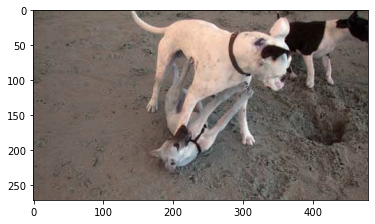

In [86]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
               'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
               'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

ann_trans = Ann2lis(voc_classes)

ind = 2
image_file_path = train_img_list[ind]
img = cv2.imread(image_file_path)
plt.imshow(img);

height, width, channels = img.shape

ann_trans(train_ann_list[ind], width, height)

In [87]:
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords,\
PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans

class DataTransform():

    def __init__(self, input_size, color_mean):
        self.data_transform = {'train': Compose([
            ConvertFromInts(),
            ToAbsoluteCoords(),
            PhotometricDistort(),
            Expand(color_mean),
            RandomSampleCrop(),
            RandomMirror(),
            ToPercentCoords(),
            Resize(input_size),
            SubtractMeans(color_mean)
        ]), 
        'val': Compose([
            ConvertFromInts(),
            Resize(input_size),
            SubtractMeans(color_mean)
        ])
        }
    
    def __call__(self, img, phase, boxes, labels):
        return self.data_transform[phase](img, boxes, labels)

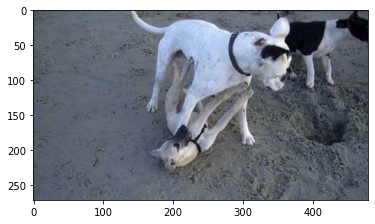

In [88]:
# check
ind = 2
image_file_path = train_img_list[ind]
img = cv2.imread(image_file_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

height, width, channels = img.shape
ann_list = ann_trans(train_ann_list[ind], width, height)

color_mean = (104, 117, 123)
transform = DataTransform(CFG.size, color_mean)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


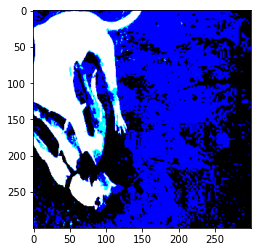

In [89]:
# Train
img_transformed, boxes, labels = transform(img, 'train', ann_list[:,:4], ann_list[:,4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


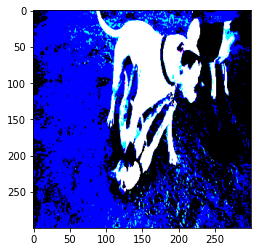

In [90]:
# Val
img_transformed, boxes, labels = transform(img, 'val', ann_list[:,:4], ann_list[:,4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB));

In [91]:
# dataset
class ImgDataset(data.Dataset):

    def __init__(self, img_list, ann_list, phase='train', transform=None, transform_ann=None,):
        self.img_list = img_list
        self.ann_list = ann_list
        self.phase = phase
        self.transform = transform
        self.transform_ann = transform_ann
    
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):

        im, gt, h, w = self.pull_item(index)
        return im, gt, h, w
    
    def pull_item(self, index):

        # image
        img_path = self.img_list[index]
        img = cv2.imread(img_path)
        height, width, channels = img.shape

        # annotations
        ann_path = self.ann_list[index]
        ann_list = self.transform_ann(ann_path, width, height)

        # 前処理
        img, boxes, labels = self.transform(img, self.phase, ann_list[:,:4], ann_list[:,4])
        img = torch.from_numpy(img[:,:,(2,1,0)]).permute(2,0,1)

        # ground truth
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        return img, gt , height, width

In [92]:
train_dataset = ImgDataset(train_img_list, train_ann_list, phase='train',
transform = DataTransform(CFG.size, color_mean), transform_ann = Ann2lis(voc_classes))

val_dataset = ImgDataset(val_img_list, val_ann_list, phase='val',
transform = DataTransform(CFG.size, color_mean), transform_ann = Ann2lis(voc_classes))


train_dataset.__getitem__(4)

(tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ..., 48.2083, 51.4455, 47.9892],
          [ 0.0000,  0.0000,  0.0000,  ..., 45.3428, 49.3900, 41.8993],
          [ 0.0000,  0.0000,  0.0000,  ..., 43.2967, 45.0239, 47.6010]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ..., 53.6217, 58.6188, 55.1625],
          [ 0.0000,  0.0000,  0.0000,  ..., 51.6948, 55.2478, 47.9218],
          [ 0.0000,  0.0000,  0.0000,  ..., 49.5668, 49.4693, 54.0117]],
 
         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,

In [93]:
# collate_fn
def det_collate_fn(batch):
    targets = []
    imgs = []

    for sample in batch:
        imgs.append(sample[0]) #img
        targets.append(torch.FloatTensor(sample[1])) # gt

    imgs = torch.stack(imgs, dim=0)

    return imgs, targets

In [94]:
# Dataloader
train_dataloader = data.DataLoader(train_dataset, batch_size=CFG.batch_size,shuffle=True, collate_fn=det_collate_fn)
val_dataloader = data.DataLoader(val_dataset,batch_size=CFG.batch_size,shuffle=False,collate_fn=det_collate_fn)

dataloader_dict = {'train':train_dataloader,'val':val_dataloader}
batch_iter = iter(dataloader_dict['train'])

inputs, targets = next(batch_iter)
print('input_size:',inputs.size())
print(len(targets))
print(targets[1].size())

input_size: torch.Size([16, 3, 300, 300])
16
torch.Size([1, 5])


In [96]:
# Data counts
print('Train:',len(train_dataloader))
print('Val:',len(val_dataloader))

Train: 358
Val: 364


In [ ]:
# SSD


In [13]:
# vgg16
model = models.vgg16(pretrained=CFG.pretrained)
model.classifier[6] = nn.Linear(in_features=4096,out_features=2)

# 訓練モード
model.train()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# 損失関数
criterion = nn.CrossEntropyLoss()

In [15]:
# 転移学習
params_update1 = []
params_update2 = []
params_update3 = []

update_layer1 = 'features'
update_layer2 = ['classifier.0.weight', 'classifier.0.bias','classifier.3.weight', 'classifier.3.bias',]
update_layer3 = ['classifier.6.weight', 'classifier.6.bias']

for name, param in model.named_parameters():
    if update_layer1 in name:
        # 学習レイヤー
        param.requires_grad = True
        params_update1.append(param)
        print('update1:',name)
    
    elif name in update_layer2:
        param.requires_grad = True
        params_update2.append(param)
        print('update2:',name)
    
    elif name in update_layer3:
        param.requires_grad = True
        params_update3.append(param)
        print('update3:',name)

    else:
        # 凍結レイヤー
        param.requires_grad = False
        print('no update_layer:',name)

update1: features.0.weight
update1: features.0.bias
update1: features.2.weight
update1: features.2.bias
update1: features.5.weight
update1: features.5.bias
update1: features.7.weight
update1: features.7.bias
update1: features.10.weight
update1: features.10.bias
update1: features.12.weight
update1: features.12.bias
update1: features.14.weight
update1: features.14.bias
update1: features.17.weight
update1: features.17.bias
update1: features.19.weight
update1: features.19.bias
update1: features.21.weight
update1: features.21.bias
update1: features.24.weight
update1: features.24.bias
update1: features.26.weight
update1: features.26.bias
update1: features.28.weight
update1: features.28.bias
update2: classifier.0.weight
update2: classifier.0.bias
update2: classifier.3.weight
update2: classifier.3.bias
update3: classifier.6.weight
update3: classifier.6.bias


In [16]:
# 最適化
optimizer = optim.SGD([
    {'params': params_update1, 'lr':0.0001},
    {'params': params_update2, 'lr':0.0005},
    {'params': params_update3, 'lr':0.001},
    ], momentum=0.9)

In [17]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epochs):

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0
            epoch_corr = 0

            if epoch == 0 and phase == 'train':
                continue

            for inputs, labels in tqdm(dataloader_dict[phase]):
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item()*inputs.size(0)
                    epoch_corr += torch.sum(preds==labels.data)
            
            epoch_loss = epoch_loss/len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corr.double()/len(dataloader_dict[phase].dataset)

            print('{} Loss:{:.4f} Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc))

train_model(model, dataloader_dict, criterion, optimizer, CFG.epoch)

  0%|          | 0/8 [00:00<?, ?it/s]val Loss:0.7751 Acc:0.4575
Epoch 2/2
100%|██████████| 5/5 [01:45<00:00, 21.12s/it]val Loss:0.1742 Acc:0.9477

